## CACTI Radars Analysis: Maps:

**Radar data map plotting and analysis test codes.**

**Hungjui Yu 20220407**

In [4]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [5]:
import sys
import time
import datetime as dt
from netCDF4 import Dataset # MFDataset
import numpy as np
import xarray as xr

import cartopy.crs as ccrs
import cartopy.feature as cfeat
import cartopy.io.img_tiles as cimgt

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import ( from_levels_and_colors, Normalize ) 

import metpy.calc as mpcalc
from metpy.interpolate import cross_section

In [6]:
from wrf import ( getvar, interplevel, to_np, get_cartopy, latlon_coords, vertcross,
                  cartopy_xlim, cartopy_ylim, interpline, CoordPair, WrfProj )

### Open radar data from local:

In [10]:
test_method = 'SAMURAI'
test_time = dt.datetime(2019, 1, 25, 22, 0, 0)

# ds_radar = xr.open_dataset('/Users/yuhungjui/Downloads/samurai_XYZ_analysis_m.nc')
ds_radar = xr.open_dataset('/Users/yuhungjui/Downloads/samurai_XYZ_analysis.nc')

### Open radar data on Maui:

In [7]:
data_path_1 = '/home/hyu/2scratch2/DATA_DOE_CACTI_cases'

#### from SAMURAI:

In [8]:
test_method = 'SAMURAI'
test_time = dt.datetime(2019, 1, 25, 22, 0, 0)

data_path_2_met = '/test_{}'.format(test_method)
data_path_3_dt = '/test_{}'.format(test_time.strftime('%Y%m%d_%H%M%S'))

data_path_full = data_path_1 \
               + data_path_2_met \
               + data_path_3_dt \
               + '/output_2ppi/samurai_XYZ_analysis.nc'
               # + '/output_2ppi_1rhi_2hsrhi/samurai_XYZ_analysis.nc'
            
ds_radar = xr.open_dataset(data_path_full)

In [10]:
# ds_radar

In [ ]:
# ds_radar.W.sel(altitude=2).plot()
# ds_radar.W.isel(altitude=4).plot()
# ds_radar.DBZ.sel(altitude=2).data[0].shape

#### from FRACTL:

#### from EVAD:

In [ ]:
# ds_radar = xr.open_dataset('/home/hyu/2scratch2/DATA_DOE_CACTI_cases/test_EVAD/output/20190125/profile.20190125_180003.CSAPR2.nc')

In [ ]:
# ds_radar

In [ ]:
# ds_radar.profile.plot()

### Set data arrays:

In [11]:
ds_radar_re=ds_radar.squeeze()

## Get variables:
da_DBZ = ds_radar_re['DBZ']
da_U = ds_radar_re['U']
da_V = ds_radar_re['V']
da_W = ds_radar_re['W']

## Mesh Lat/Lon:
lon, lat = np.meshgrid( ds_radar_re.longitude, ds_radar_re.latitude )

### Plot 1: Maps:

#### Set plotting parameters:

In [12]:
plot_alt = 2.5 #km

#### Set cross-section parameters:

In [13]:
## Set the LON/LAT for cross-section Start/End points:
xsec1_LON = [-65.3, -63.5]
xsec1_LAT = [-33, -30.5]

In [19]:
xsec_LON = xsec1_LON
xsec_LAT = xsec1_LAT

#### Function: Creating new map:

In [14]:
def new_map(fig):
    
    # proj = ccrs.LambertConformal( central_longitude=0.0, central_latitude=30, globe=None )
    # proj = ccrs.LambertCylindrical( central_longitude=0.0, globe=None )
    proj = ccrs.PlateCarree( central_longitude=0, globe=None)
    
    # ax = fig.add_subplot(1, 1, 1, projection=proj)
    ax = plt.axes(projection=proj)
    
    ## Add background image:
    # ax.stock_img()
    
    ## Add Stamen terrain:
    stamen_terrain = cimgt.Stamen('terrain')
    
    ax.add_image(stamen_terrain, 8)
    
    ## Set extent:
    # ax.set_global()
    
    ## S. America:
    # ax.set_extent([-30, -90, 20, -60], crs=proj)
    ## CACTI:
    # ax.set_extent([-61.5, -67, -28.5, -34.5], crs=proj)
    ax.set_extent([-61.9, -66.5, -29.5, -34.1], crs=proj)
    # ax.set_extent([-62.5, -66, -29.5, -33.5], crs=proj)
    # ax.set_extent([-55, -75, -20, -40], crs=proj)
    
    ## Add coast lines:
    ax.coastlines('10m', 'black', linewidth=1)
    
    ## Grab state shapefile:
    state_borders = cfeat.NaturalEarthFeature( category='cultural' # 'physical'
                                             , name='admin_1_states_provinces_lines'
                                             # , name='geography_regions_elevation_points'
                                             , scale='50m'
                                             , facecolor='none'
                                             , edgecolor='gray'
                                             )
    ## Add features:
    # ax.add_feature(cfeat.BORDERS)
    # ax.add_feature(cfeat.LAND)
    # ax.add_feature(cfeat.COASTLINE)
    # ax.add_feature(cfeat.OCEAN, edgecolor=None) #, fc='none')
    # ax.add_feature(cfeat.GSHHSFeature(scale='auto', levels=None))
    # ax.add_feature(state_borders, linewidth=0.8)
    
    ## Add the gridlines:
    latlon_grid_int = 1
    ax_gl = ax.gridlines( crs=ccrs.PlateCarree()
                        , linewidth=0.5
                        , color='#454545' 
                        , alpha=0.9
                        , linestyle='--'
                        , draw_labels=True 
                        , dms=True
                        # , x_inline=False 
                        # , y_inline=False
                        , xlocs=np.arange(-180, 181, latlon_grid_int)
                        , ylocs=np.arange(-90, 91, latlon_grid_int)
                        )
    ax_gl.top_labels = False
    ax_gl.right_labels = False
    ax_gl.bottom_labels = True
    ax_gl.left_labels = True
    ax_gl.xlabel_style = {'size': 14, 'weight': 'bold'}
    ax_gl.ylabel_style = {'size': 14, 'weight': 'bold'}
    
    
    return ax

#### Plot dBZ:

In [15]:
## Set NWS reflectivity colorbar:
from metpy.plots import ctables
ref_norm, ref_cmap = ctables.registry.get_with_steps('NWSStormClearReflectivity', -20, 0.5)

## Set CWB reflectivity colorbar:
clevs = [-5,0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,85]
ccols = ['#ffffff','#98ffff','#009aff','#1919ff','#19ff19','#19cd19','#19A019','#fefe08','#ffcb00','#ff9c00','#fe0005','#c90200','#9d0000','#9a009d','#cf00d7','#ff00f7','#fdcafe']
# clevs = [-30,-25,-20,-15,-10,-5,0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,85]
# ccols = ['#f0f8ff','#f0f8ff','#f0f8ff','#f0f8ff','#f0f8ff','#f0f8ff','#98ffff','#009aff','#1919ff','#19ff19','#19cd19','#19A019','#fefe08','#ffcb00','#ff9c00','#fe0005','#c90200','#9d0000','#9a009d','#cf00d7','#ff00f7','#fdcafe']

In [50]:
# np.datetime_as_string(ds_radar.time.data[0], unit='s')
# str(ds_radar.time.data[0])[:19] #.strftime('%Y-%m-%d T%H:%M:%SZ') 
ds_radar.time.data[0].astype('datetime64[s]').item().strftime('%Y%m%d_%H%M%S')

'20190125_22:00:03'

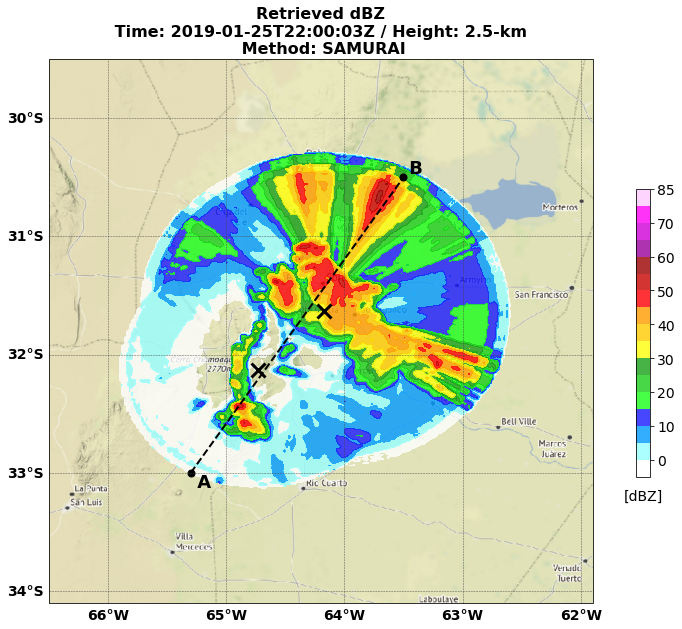

In [88]:
fig = plt.figure(figsize=(10,10))
ax1 = new_map(fig)
# ax1 = plt.axes(projection = ccrs.LambertConformal(central_longitude=-100, central_latitude=40))
# ax1 = plt.axes(projection = ccrs.PlateCarree())

plotting_var = ds_radar.DBZ.sel(altitude=plot_alt).data[0]
plotting_lon = ds_radar.longitude
plotting_lat = ds_radar.latitude


## CWB colorbar:
cf1 = ax1.contourf( plotting_lon, plotting_lat, plotting_var
                  , levels=clevs, colors=ccols
                  , alpha=0.8
                  )

## NWS colorbar:
# cf1 = ax1.pcolormesh( plotting_lon, plotting_lat, plotting_var
#                     , cmap=ref_cmap, norm=ref_norm
#                     , alpha=0.8
#                     , shading='auto'
#                     )
# cf1 = ax1.pcolormesh( plotting_lon, plotting_lat, plotting_var
#                     , vmax=70
#                     , vmin=-5
#                     , cmap=ctables.registry.get_colortable('NWSReflectivity')
#                     # , norm=Normalize(-5, 75)
#                     )

## Loc. CSAPR2:
plt.plot( -64.73, -32.13
        # , color='k'
        , marker='x'
        , markersize=14
        , mec='k'
        , mew=3
        , mfc='none'
        # , markevery=[0,-1]
        # , linewidth=1.0
        # , linestyle='--'
        )

## Loc. CHIVO:
plt.plot( -64.17, -31.63
        # , color='k'
        , marker='x'
        , markersize=14
        , mec='k'
        , mew=3
        , mfc='none'
        # , markevery=[0,-1]
        # , linewidth=1.0
        # , linestyle='--'
        )

## Cross-sections:
plt.plot( xsec1_LON, xsec1_LAT
        , color='k'
        , marker='.'
        , markersize=14
        # , mec='k'
        # , mew=1
        # , mfc='k'
        , markevery=[0,-1]
        , linewidth=2.0
        , linestyle='--'
        )
plt.text( xsec_LON[0], xsec_LAT[0], ' A '
        , fontsize=18
        , fontweight='bold'
        , va='top'
        )
plt.text( xsec_LON[1], xsec_LAT[1], ' B '
        , fontsize=18
        , fontweight='bold'
        , va='bottom'
        )

cf1_title = plt.title( 'Retrieved dBZ'
                     # + test_time.strftime('%Y-%m-%d T%H:%M:%SZ') 
                     + '\n Time: ' + np.datetime_as_string(ds_radar.time.data[0], unit='s') + 'Z'
                     + ' / Height: ' + str(plot_alt) + '-km'
                     + ' \n Method: ' + test_method
                     ,fontsize=16
                     ,fontweight='bold'
                     )

cbar_ax = fig.add_axes([0.95, 0.3, 0.02, 0.4])
cbar = fig.colorbar(cf1, cax=cbar_ax, fraction=0.04)
cbar.ax.tick_params(labelsize=14)
cbar.ax.set_title('[dBZ]', fontsize=14, y=-0.1) #fontweight='bold'


## Save figure:
plt.savefig( test_time.strftime('%Y%m%d_%H%M%S')
             # './' + ds_radar.time.data[0].astype('datetime64[s]').item().strftime('%Y%m%d_%H%M%S')
           + '_map_DBZ_xline.png'
           , bbox_inches='tight'
           , dpi=300
           )



#### Plot W:

In [75]:
## W Colormap settings:
w_bounds = np.arange(-5, 5.1, 0.5)
w_cmap = cm.get_cmap('RdBu_r', w_bounds.size+1)
w_norm = mpl.colors.BoundaryNorm(w_bounds, w_cmap.N, extend='both')


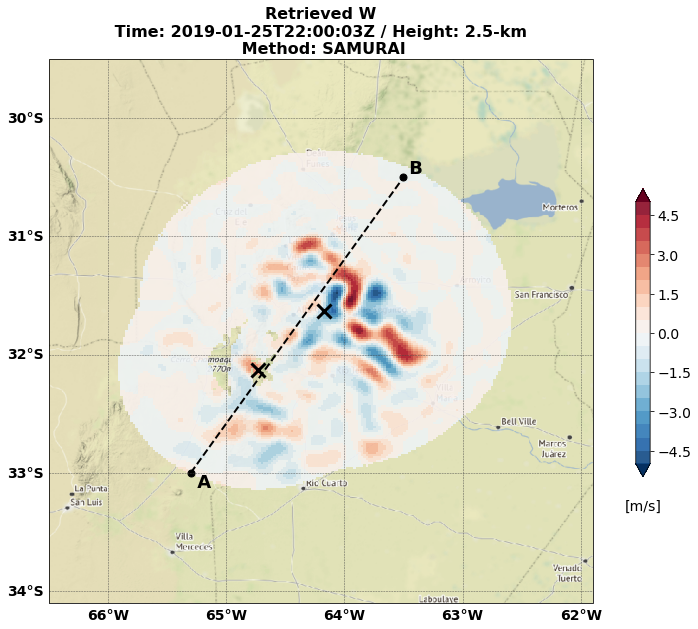

In [87]:
fig = plt.figure(figsize=(10,10))
ax1 = new_map(fig)
# ax1 = plt.axes(projection = ccrs.LambertConformal(central_longitude=-100, central_latitude=40))
# ax1 = plt.axes(projection = ccrs.PlateCarree())

plotting_var = ds_radar.W.sel(altitude=plot_alt).data[0]
plotting_lon = ds_radar.longitude
plotting_lat = ds_radar.latitude


cf1 = ax1.pcolormesh( plotting_lon, plotting_lat, plotting_var
                    , cmap=w_cmap
                    , norm=w_norm
                    , alpha=0.9
                    , shading='auto')


## Loc. CSAPR2:
plt.plot( -64.73, -32.13
        # , color='k'
        , marker='x'
        , markersize=14
        , mec='k'
        , mew=3
        , mfc='none'
        # , markevery=[0,-1]
        # , linewidth=1.0
        # , linestyle='--'
        )

## Loc. CHIVO:
plt.plot( -64.17, -31.63
        # , color='k'
        , marker='x'
        , markersize=14
        , mec='k'
        , mew=3
        , mfc='none'
        # , markevery=[0,-1]
        # , linewidth=1.0
        # , linestyle='--'
        )

## Cross-sections:
plt.plot( xsec1_LON, xsec1_LAT
        , color='k'
        , marker='.'
        , markersize=14
        # , mec='k'
        # , mew=1
        # , mfc='k'
        , markevery=[0,-1]
        , linewidth=2.0
        , linestyle='--'
        )
plt.text( xsec_LON[0], xsec_LAT[0], ' A '
        , fontsize=18
        , fontweight='bold'
        , va='top'
        )
plt.text( xsec_LON[1], xsec_LAT[1], ' B '
        , fontsize=18
        , fontweight='bold'
        , va='bottom'
        )

cf1_title = plt.title( 'Retrieved W'
                     # + test_time.strftime('%Y-%m-%d T%H:%M:%SZ') 
                     + '\n Time: ' + np.datetime_as_string(ds_radar.time.data[0], unit='s') + 'Z'
                     + ' / Height: ' + str(plot_alt) + '-km'
                     + ' \n Method: ' + test_method
                     ,fontsize=16
                     ,fontweight='bold'
                     )

cbar_ax = fig.add_axes([0.95, 0.3, 0.02, 0.4])
cbar = fig.colorbar(cf1, fraction=0.04, cax=cbar_ax)
cbar.ax.tick_params(labelsize=14)
cbar.ax.set_title('[m/s]', fontsize=14, y=-0.2) #fontweight='bold'


## Save figure:
plt.savefig( test_time.strftime('%Y%m%d_%H%M%S')
             # './' + ds_radar.time.data[0].astype('datetime64[s]').item().strftime('%Y%m%d_%H%M%S')
           + '_map_W_xline.png'
           , bbox_inches='tight'
           , dpi=300
           )


### <font color='dodgerblue'>**Supplement Codes from Marqi:**</font>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from astropy.convolution import convolve, Gaussian2DKernel
import pyart
from csu_radartools import (csu_fhc, csu_liquid_ice_mass, csu_blended_rain, 
                            csu_dsd, csu_kdp, csu_misc, fundamentals)
import csu_radartools
import matplotlib.colors as colors
import difflib
import os
from datetime import datetime


In [ ]:
print (csu_radartools.__version__)

In [ ]:
def two_panel_plot(radar, sweep=0, var1='reflectivity', vmin1=0, vmax1=70,
                   cmap1='pyart_HomeyerRainbow', units1='dBZ', var2='differential_reflectivity',
                   vmin2=-5, vmax2=5, cmap2='RdYlBu_r', units2='dB', return_flag=False,
                   xlim=[-150,150], ylim=[-150,150]):
    display = pyart.graph.RadarDisplay(radar)
    fig = plt.figure(figsize=(18,5))
    fig.patch.set_facecolor('xkcd:white')
    ax1 = fig.add_subplot(121)
    display.plot_rhi(var1, sweep=sweep, vmin=vmin1, vmax=vmax1, cmap=cmap1, 
                     colorbar_label=units1, mask_outside=True)
    display.set_limits(xlim=xlim, ylim=ylim)
    ax2 = fig.add_subplot(122)
    display.plot_rhi(var2, sweep=sweep, vmin=vmin2, vmax=vmax2, cmap=cmap2, 
                     colorbar_label=units2, mask_outside=True)
    display.set_limits(xlim=xlim, ylim=ylim)
    if return_flag:
        return fig, ax1, ax2, display

In [ ]:
#radarfile = '/home/mrocque/research/relampago/csapr2/corcsapr2cfrppiqcM1.b1.20181214.030003.custom.nc2'
radarfile = '/home/mrocque/research/relampago/csapr2/corcsapr2cfrppiqcM1.b1.20181214.140003.custom.nc1'
#radarfile = '/rasmussen-scratch/krasmussen/DATA/RELAMPAGO/CSAPR2/ppi/20181214/corcsapr2cfrppiqcM1.b1.20181214.141504.custom.nc'
#radarfile = '/rasmussen-scratch/krasmussen/DATA/RELAMPAGO/CSAPR2/ppi/20181214/corcsapr2cfrppiqcM1.b1.20181214.234504.custom.nc'
#radarfile = '/home/mrocque/research/relampago/csapr2/corcsapr2cfrhsrhiqcM1.b1.20181214.030715.custom.nc2'
radar = pyart.io.read(radarfile)
print(radar.fields.keys())

dz = radar.fields['DZ_qc']['data']
dr = radar.fields['ZDR_qc']['data']
kd = radar.fields['PHIDP_qc']['data']
rh = radar.fields['RHOHV_qc']['data']

In [ ]:
del radar.fields['uncorrected_reflectivity_v']

In [ ]:
print (radar.fields.keys())

In [ ]:
snd_times = []
filenames = []
for filename in os.listdir('/rasmussen-scratch/mrocque/research/relampago/CACTI_ARM_soundings/netcdf/'):
    filenames.append(filename)
    str2 = (filename[18:33])
    snd_times.append(datetime.strptime(str2, '%Y%m%d.%H%M%S'))


In [ ]:
filenames.sort()
snd_times.sort()

In [ ]:
print (snd_times)

In [ ]:
#str1 = radarfile[63:78]
str1 = radarfile[88:103]
print (str1)

#closest = difflib.get_close_matches(str1, snd_times, 1)
#print (snd_times.index(closest[0]))

In [ ]:
dt_obj = datetime.strptime(str1, '%Y%m%d.%H%M%S')

res = min(snd_times, key=lambda sub: abs(sub - dt_obj))


In [ ]:
print (dt_obj)

In [ ]:
print (res)
print (snd_times.index(res))

In [ ]:
print (filenames[339])

In [ ]:
#584
#707

print (filenames[340])

In [ ]:
sndfile = '/rasmussen-scratch/mrocque/research/relampago/CACTI_ARM_soundings/netcdf/corsondewnpnM1.b1.20181214.000000.custom.cdf'

data = Dataset(sndfile, 'r')
print (data.variables.keys())
temp = np.array(data.variables['tdry'])
hght = np.array(data.variables['alt'])

In [ ]:
print (data.variables['base_time'])

In [ ]:
def radar_coords_to_cart(rng, az, ele, debug=False):
    """
    TJL - taken from old Py-ART version
    Calculate Cartesian coordinate from radar coordinates
    Parameters
    ----------
    rng : array
        Distances to the center of the radar gates (bins) in kilometers.
    az : array
        Azimuth angle of the radar in degrees.
    ele : array
        Elevation angle of the radar in degrees.
    Returns
    -------
    x, y, z : array
        Cartesian coordinates in meters from the radar.
    Notes
    -----
    The calculation for Cartesian coordinate is adapted from equations
    2.28(b) and 2.28(c) of Doviak and Zrnic [1]_ assuming a
    standard atmosphere (4/3 Earth's radius model).
    .. math::
        z = \\sqrt{r^2+R^2+r*R*sin(\\theta_e)} - R
        s = R * arcsin(\\frac{r*cos(\\theta_e)}{R+z})
        x = s * sin(\\theta_a)
        y = s * cos(\\theta_a)
    Where r is the distance from the radar to the center of the gate,
    :math:\\theta_a is the azimuth angle, :math:\\theta_e is the
    elevation angle, s is the arc length, and R is the effective radius
    of the earth, taken to be 4/3 the mean radius of earth (6371 km).
    References
    ----------
    .. [1] Doviak and Zrnic, Doppler Radar and Weather Observations, Second
        Edition, 1993, p. 21.
    """
    theta_e = ele * np.pi / 180.0  # elevation angle in radians.
    theta_a = az * np.pi / 180.0  # azimuth angle in radians.
    R = 6371.0 * 1000.0 * 4.0 / 3.0  # effective radius of earth in meters.
    r = rng * 1000.0  # distances to gates in meters.

    z = (r ** 2 + R ** 2 + 2.0 * r * R * np.sin(theta_e)) ** 0.5 - R
    s = R * np.arcsin(r * np.cos(theta_e) / (R + z))  # arc length in m.
    x = s * np.sin(theta_a)
    y = s * np.cos(theta_a)
    return x, y, z


def get_z_from_radar(radar):
    """Input radar object, return z from radar (km, 2D)"""
    azimuth_1D = radar.azimuth['data']
    elevation_1D = radar.elevation['data']
    srange_1D = radar.range['data']
    sr_2d, az_2d = np.meshgrid(srange_1D, azimuth_1D)
    el_2d = np.meshgrid(srange_1D, elevation_1D)[1]
    xx, yy, zz = radar_coords_to_cart(sr_2d/1000.0, az_2d, el_2d)
    return zz + radar.altitude['data']

def check_sounding_for_montonic(sounding):
    """
    So the sounding interpolation doesn't fail, force the sounding to behave
    monotonically so that z always increases. This eliminates data from
    descending balloons.
    """
    snd_T = np.array(sounding.variables['tdry'])
    snd_z = np.array(sounding.variables['alt'])
    
    #snd_T = sounding.soundingdata['temp']  # In old SkewT, was sounding.data
    #snd_z = sounding.soundingdata['hght']  # In old SkewT, was sounding.data
    dummy_z = []
    dummy_T = []
    #if not snd_T.mask[0]: #May cause issue for specific soundings
    dummy_z.append(snd_z[0])
    dummy_T.append(snd_T[0])
    for i, height in enumerate(snd_z):
        if i > 0:
            if snd_z[i] > snd_z[i-1]:# and not snd_T.mask[i]:
                dummy_z.append(snd_z[i])
                dummy_T.append(snd_T[i])
    snd_z = np.array(dummy_z)
    snd_T = np.array(dummy_T)
    return snd_T, snd_z


def interpolate_sounding_to_radar(sounding, radar):
    """Takes sounding data and interpolates it to every radar gate."""
    radar_z = get_z_from_radar(radar)
    radar_T = None
    snd_T, snd_z = check_sounding_for_montonic(sounding)
    shape = np.shape(radar_z)
    rad_z1d = radar_z.ravel()
    rad_T1d = np.interp(rad_z1d, snd_z, snd_T)
    return np.reshape(rad_T1d, shape), radar_z


In [ ]:
radar_T, radar_z = interpolate_sounding_to_radar(data, radar)

In [ ]:
scores = csu_fhc.csu_fhc_summer(dz=dz, zdr=dr, rho=rh, kdp=kd, use_temp=True, band='C',
                                T=radar_T, method='hybrid')#, use_trap=True)

fh = np.argmax(scores, axis=0) + 1

In [ ]:
def add_field_to_radar_object(field, radar, field_name='HID_hyb', units='unitless', 
                              long_name='Hydrometeor ID', standard_name='Hydrometeor ID',
                              dz_field='DZ_qc'):
    """
    Adds a newly created field to the Py-ART radar object. If reflectivity is a masked array,
    make the new field masked the same as reflectivity.
    """
    fill_value = -32768
    masked_field = np.ma.asanyarray(field)
    masked_field.mask = masked_field == fill_value
    if hasattr(radar.fields[dz_field]['data'], 'mask'):
        setattr(masked_field, 'mask', 
                np.logical_or(masked_field.mask, radar.fields[dz_field]['data'].mask))
        fill_value = radar.fields[dz_field]['_FillValue']
    field_dict = {'data': masked_field,
                  'units': units,
                  'long_name': long_name,
                  'standard_name': standard_name,
                  '_FillValue': fill_value}
    radar.add_field(field_name, field_dict, replace_existing=True)
    return radar

In [ ]:
radar = add_field_to_radar_object(fh, radar)


In [ ]:
hid_colors = ['White', 'LightBlue', 'MediumBlue', 'DarkOrange', 'LightPink',
              'Cyan', 'DarkGray', 'Lime', 'Yellow', 'Red', 'Fuchsia']
cmaphid = colors.ListedColormap(hid_colors)
cmapmeth = colors.ListedColormap(hid_colors[0:6])
cmapmeth_trop = colors.ListedColormap(hid_colors[0:7])

def adjust_fhc_colorbar_for_pyart(cb):
    cb.set_ticks(np.arange(1.4, 10, 0.9))
    cb.ax.set_yticklabels(['Drizzle', 'Rain', 'Ice Crystals', 'Aggregates',
                           'Wet Snow', 'Vertical Ice', 'LD Graupel',
                           'HD Graupel', 'Hail', 'Big Drops'])
    cb.ax.set_ylabel('')
    cb.ax.tick_params(length=0)
    return cb

def adjust_meth_colorbar_for_pyart(cb, tropical=False):
    if not tropical:
        cb.set_ticks(np.arange(1.25, 5, 0.833))
        cb.ax.set_yticklabels(['R(Kdp, Zdr)', 'R(Kdp)', 'R(Z, Zdr)', 'R(Z)', 'R(Zrain)'])
    else:
        cb.set_ticks(np.arange(1.3, 6, 0.85))
        cb.ax.set_yticklabels(['R(Kdp, Zdr)', 'R(Kdp)', 'R(Z, Zdr)', 'R(Z_all)', 'R(Z_c)', 'R(Z_s)'])
    cb.ax.set_ylabel('')
    cb.ax.tick_params(length=0)
    return cb

In [ ]:
# Actual plotting done here
lim = [0, 100]
lim2 = [0, 20]
fig, ax1, ax2, display = two_panel_plot(
    radar, sweep=3, var1='DZ_qc', vmin1=0, vmax1=70, var2='HID_hyb', vmin2=0, vmax2=10,
    cmap2=cmaphid, units2='', return_flag=True, xlim=lim, ylim=lim2)
display.cbs[1] = adjust_fhc_colorbar_for_pyart(display.cbs[1])

#plt.savefig('caspr2_20181214_030715_30rhi_hid_hyb.png', dpi=400, bbox_inches='tight')

In [ ]:
plt.plot(temp, hght)
plt.xlim(-10, 10)